In [229]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import plotly.express as px
import os
import pandas as pd
import torch.nn.functional as F

In [98]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

In [100]:
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [176]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(train_dataloader, idx):
        train_features = next(iter(train_dataloader))
        train_labels = next(iter(train_dataloader))
        image = train_features.iloc[idx, 1:].values.reshape(1, 28, 28)
        label = train_labels.iloc[idx, 0]
        return image, label

This is a: 0 - T-shirt


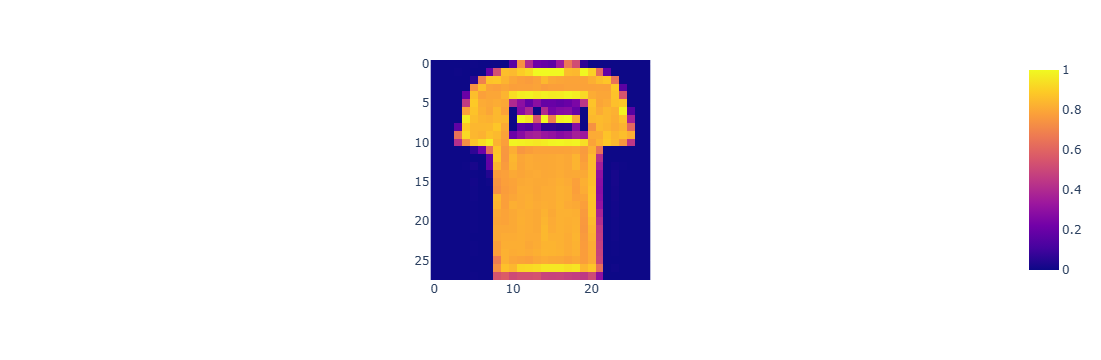

In [195]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

idx=1
print(f"This is a: {train_data.__getitem__(idx)[1]} - {labels_map[0]}")
px.imshow(train_data.__getitem__(idx)[0].reshape(28, 28)) 

In [203]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_relu_model(x)
        return output
        
model = NeuralNetwork()

In [205]:
learning_rate = 1e-2
batch_size = 64
epochs = 20 

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),
     lr=learning_rate)

In [219]:
def train_loop (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [221]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {
        (100*correct):>0.1f}%, Avg loss: {
            test_loss:>8f} \n")

In [223]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297853  [   64/60000]
loss: 2.296087  [  704/60000]
loss: 2.273955  [ 1344/60000]
loss: 2.256788  [ 1984/60000]
loss: 2.243447  [ 2624/60000]
loss: 2.245672  [ 3264/60000]
loss: 2.214842  [ 3904/60000]
loss: 2.186137  [ 4544/60000]
loss: 2.177269  [ 5184/60000]
loss: 2.175996  [ 5824/60000]
loss: 2.162212  [ 6464/60000]
loss: 2.123694  [ 7104/60000]
loss: 2.099010  [ 7744/60000]
loss: 2.054850  [ 8384/60000]
loss: 2.044260  [ 9024/60000]
loss: 2.026333  [ 9664/60000]
loss: 2.036669  [10304/60000]
loss: 1.943534  [10944/60000]
loss: 1.933139  [11584/60000]
loss: 1.866241  [12224/60000]
loss: 1.822624  [12864/60000]
loss: 1.858722  [13504/60000]
loss: 1.818797  [14144/60000]
loss: 1.659481  [14784/60000]
loss: 1.702116  [15424/60000]
loss: 1.705331  [16064/60000]
loss: 1.520067  [16704/60000]
loss: 1.565074  [17344/60000]
loss: 1.546846  [17984/60000]
loss: 1.490270  [18624/60000]
loss: 1.507752  [19264/60000]
loss: 1.447120  [19904/60000]


In [225]:
EPOCH = epochs
PATH = "model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [227]:
PATH = "model.pt"

model = NeuralNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
EPOCH = checkpoint['epoch']

C:\Users\tino7\AppData\Local\Temp\ipykernel_53532\1275933610.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

